In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
# --- 1. CẤU HÌNH THAM CHIẾU (Daily Values) ---
# Dựa trên FDA/DGA cho khẩu phần 2000 kcal
DV_NRF9 = {
    'Protein (g)': 50,
    'Fiber, total dietary (g)': 28,
    'Vitamin A, RAE (mcg_RAE)': 900,
    'Vitamin C (mg)': 90,
    'Vitamin E (alpha-tocopherol) (mg)': 15,
    'Calcium (mg)': 1300,
    'Iron\n(mg)': 18,
    'Magnesium (mg)': 420,
    'Potassium (mg)': 4700
}
# Giới hạn cho các chất cần hạn chế (LIM)
MRV_LIM = {
    'Fatty acids, total saturated (g)': 20,
    'Added Sugar (g)': 50,  # Ngưỡng chuẩn 50g
    'Sodium (mg)': 2300
}

In [13]:
# --- 2. HÀM TÍNH ĐIỂM CƠ BẢN ---
def calc_score_capped(amount, ref_value):
    """Tính điểm giới hạn tối đa 100"""
    if pd.isna(amount) or ref_value == 0: return 0
    return min((amount / ref_value) * 100, 100)

def calc_score_uncapped(amount, ref_value):
    """Tính điểm không giới hạn"""
    if pd.isna(amount) or ref_value == 0: return 0
    return (amount / ref_value) * 100


In [14]:
"""Phân loại Good/Medium/Bad (Lower limit: 10, Upper limit: 80)"""
# Bad: <= 10
# Medium: > 10 - < 80
# Good: >= 80
def classify_fixed(score):
    if score >= 80: return 'Good'
    elif score <= 10: return 'Bad'
    else: return 'Medium'

In [15]:
# --- 3. HÀM TÍNH TOÁN CHÍNH (STANDARD) ---
def calculate_nrf_standard(df):
    df = df.copy()

    print("--- Bắt đầu tính điểm NRF9.3 (Per 100 kcal) ---")

    # A. Ổn định dữ liệu đầu vào
    # Đảm bảo cột Energy tồn tại
    if 'Energy (kcal)' not in df.columns:
        raise ValueError("Thiếu cột 'Energy (kcal)' - Không thể chuẩn hóa năng lượng!")

    # Đảm bảo cột Added Sugar (g) tồn tại (Đã làm ở Phase 1)
    if 'Added Sugar (g)' not in df.columns:
        # Fallback: Nếu lỡ chưa có thì tính tạm từ tsp
        if 'ADD_SUGARS (tsp. eq.)' in df.columns:
            print(" Cảnh báo: Tự động tính Added Sugar (g) từ tsp.")
            df['Added Sugar (g)'] = df['ADD_SUGARS (tsp. eq.)'] * 4.2
        else:
            raise ValueError("Thiếu cột 'Added Sugar (g)'!")
    # B. Chuẩn hóa về 100 kcal (Nutrient Density) với Energy Floor
    # Energy Floor = 5 kcal (để tránh lỗi chia 0 và phóng đại quá mức cho món < 5 kcal)
    # Nếu Energy < 5, coi như là 5 để tính toán.

    # 1. Tạo cột Energy mẫu số (denominator) với ngưỡng sàn là 5
    energy_denominator = df['Energy (kcal)'].clip(lower=5)

    # 2. Tính hệ số Factor
    df['Energy_Factor'] = 100 / energy_denominator

    # Lưu ý: Với các món 0 kcal hoặc <5 kcal, chúng ta vẫn tính điểm dựa trên giả định là 5 kcal
    # Điều này giúp trà, cafe không bị điểm vô cực, nhưng cũng không bị 0 điểm oan uổng.

    # C. Tính điểm NRF9 (9 chất tích cực)
    nrf9_scores = []
    for nut, dv in DV_NRF9.items():
        if nut not in df.columns:
            print(f"❌ Thiếu cột dinh dưỡng: {nut}")
            continue

        # 1. Tính lượng trong 100kcal
        amount_per_100kcal = df[nut] * df['Energy_Factor']

        # 2. Tính điểm so với DV
        score = amount_per_100kcal.apply(lambda x: calc_score_capped(x, dv))

        df[f'Score_{nut}'] = score
        nrf9_scores.append(score)

    df['Total_NRF9'] = sum(nrf9_scores)
    # D. Tính điểm LIM (3 chất hạn chế)
    lim_scores = []
    for nut, mrv in MRV_LIM.items():
        # Map tên cột (vì tên trong MRV có thể khác tên cột thực tế 1 chút)
        col_name = nut
        if nut not in df.columns:
             print(f"❌ Thiếu cột LIM: {nut}")
             continue
        # 1. Tính lượng trong 100kcal
        amount_per_100kcal = df[col_name] * df['Energy_Factor']

        # 2. Tính điểm (LIM KHÔNG giới hạn - Phạt nặng nếu vượt ngưỡng)
        # Ví dụ: 200% đường -> Trừ 200 điểm
        score = amount_per_100kcal.apply(lambda x: calc_score_uncapped(x, mrv))

        df[f'Score_{nut}'] = score
        lim_scores.append(score)

    df['Total_LIM'] = sum(lim_scores)
    # E. Tính điểm cuối cùng
    # NRF9.3 = Tổng điểm tích cực - Tổng điểm hạn chế
    df['NRF9.3_Score'] = df['Total_NRF9'] - df['Total_LIM']

    # Phân loại
    df['Label_Text'] = df['NRF9.3_Score'].apply(classify_fixed)

    # Mã hóa nhãn (0: Bad, 1: Medium, 2: Good)
    label_map = {'Bad': 0, 'Medium': 1, 'Good': 2}
    df['Label_Value'] = df['Label_Text'].map(label_map)

    print(" Tính toán hoàn tất!")
    return df

In [17]:
# 1. Load dữ liệu sạch từ Phase 1
input_file = '/content/drive/MyDrive/DAV/processed_data.csv'
df = pd.read_csv(input_file)
df_labeled = calculate_nrf_standard(df)

--- Bắt đầu tính điểm NRF9.3 (Per 100 kcal) ---
 Tính toán hoàn tất!


In [18]:
print("\nPhân phối nhãn (Quality Label):")
print(df_labeled['Label_Text'].value_counts())

# 4. Xem thử vài món Good/Bad
print("\nTop 5 món điểm cao nhất (Good):")
print(df_labeled.nlargest(5, 'NRF9.3_Score')[['DESCRIPTION', 'NRF9.3_Score', 'Label_Text']])

# 5. Lưu file kết quả để dùng cho Phase 3 (Modeling)
output_file = '/content/drive/MyDrive/DAV/labeled_data_final.csv'
df_labeled.to_csv(output_file, index=False)
print(f"\n Đã lưu file kết quả: {output_file}")


Phân phối nhãn (Quality Label):
Label_Text
Medium    4044
Bad       2375
Good       661
Name: count, dtype: int64

Top 5 món điểm cao nhất (Good):
                               DESCRIPTION  NRF9.3_Score Label_Text
5572                      Beet greens, raw    535.660951       Good
5626                          Spinach, raw    533.536948       Good
6419        Spinach, for use on a sandwich    533.536948       Good
7061        Spinach, cooked, as ingredient    529.399404       Good
5627  Spinach, fresh, cooked, no added fat    506.967766       Good

 Đã lưu file kết quả: /content/drive/MyDrive/DAV/labeled_data_final.csv


In [19]:
# --- 4. HÀM VẼ ĐỒ THỊ (VISUALIZATION) ---
def plot_results(df):
    """Vẽ biểu đồ phân phối điểm và nhãn"""
    plt.figure(figsize=(15, 6))

    # 1. Histogram phân phối điểm
    plt.subplot(1, 2, 1)
    sns.histplot(df['NRF9.3_Score'], bins=50, kde=True, color='skyblue', edgecolor='black')
    # Vẽ các đường ngưỡng
    plt.axvline(x=10, color='red', linestyle='--', label='Bad Threshold (10)')
    plt.axvline(x=80, color='green', linestyle='--', label='Good Threshold (80)')
    plt.title('Phân phối điểm NRF9.3 (Standardized)')
    plt.xlabel('NRF9.3 Score')
    plt.ylabel('Số lượng món ăn')
    plt.legend()

    # 2. Bar chart số lượng nhãn
    plt.subplot(1, 2, 2)
    order = ['Bad', 'Medium', 'Good']
    colors = {'Bad': '#ff9999', 'Medium': '#ffcc99', 'Good': '#99ff99'}
    ax = sns.countplot(data=df, x='Label_Text', order=order, palette=colors)
    plt.title('Số lượng món ăn theo phân loại')
    plt.xlabel('Nhãn')
    plt.ylabel('Số lượng')

    # Thêm số liệu trên cột
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points')

    plt.tight_layout()
    plt.show()

/tmp/ipython-input-758038522.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x='Label_Text', order=order, palette=colors)


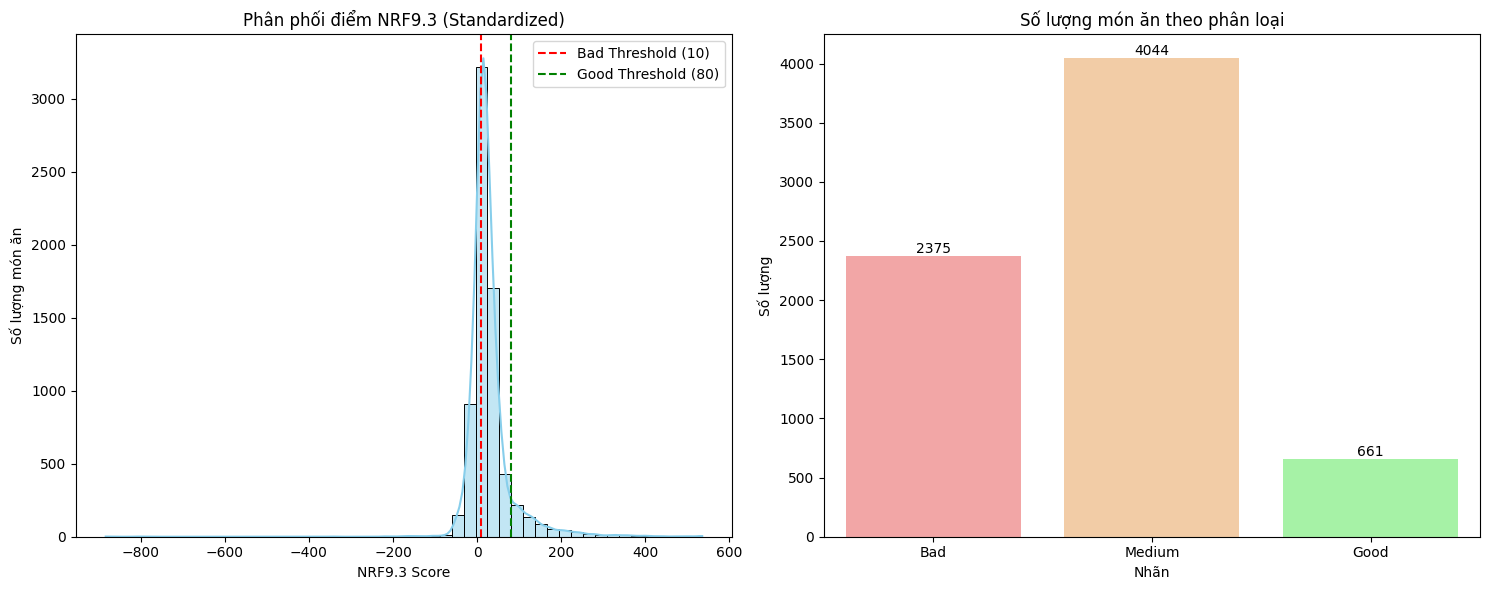

In [20]:
plot_results(df_labeled)